# EPASS for Tiny ImageNet-200 using ConvNeXt

This notebook implements an EPASS (Ensemble Projectors) model using a pretrained ConvNeXt-Small backbone from TIMM. It fine-tunes on Tiny ImageNet-200 and, after every epoch, computes validation accuracy, macro F1 score, and multi-class AUC. The metrics are saved in a dictionary (persisted as a JSON file) and the model state is saved so you can run 5 epochs now and later resume training.

In [1]:
import os

# Download and extract Tiny ImageNet if not already present

dataset_dir = "/content/tiny-imagenet-200"
dataset_zip = "/content/tiny-imagenet-200.zip"
dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

if not os.path.exists(dataset_dir):
    print("Downloading Tiny ImageNet...")
    !wget -q {dataset_url} -O {dataset_zip}
    print("Extracting files...")
    !unzip -q {dataset_zip} -d /content/
    os.remove(dataset_zip)
    print("Dataset downloaded and extracted!")
else:
    print("Tiny ImageNet already exists!")

Extracting files...
Dataset downloaded and extracted!


In [2]:
# Import libraries and set device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import timm
import json

# Additional metrics from scikit-learn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = 200
batch_size = 64

Using device: cuda


In [3]:
# Define data transforms and load the dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Number of classes:", len(train_dataset.classes))

Train samples: 100000
Val samples: 10000
Number of classes: 200


In [4]:
# Fix validation labels using val_annotations.txt
val_ann_file = os.path.join(val_dir, "val_annotations.txt")
val_label_map = {}
with open(val_ann_file, "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        file_name, label_id = parts[0], parts[1]
        val_label_map[file_name] = label_id

# Map training folder names (WordNet IDs) to numeric indices
label_ids = {folder: idx for idx, folder in enumerate(train_dataset.classes)}

# Update validation dataset labels
for i in range(len(val_dataset.imgs)):
    file_path, _ = val_dataset.imgs[i]
    file_name = os.path.basename(file_path)
    true_label_id = val_label_map[file_name]
    val_dataset.imgs[i] = (file_path, label_ids[true_label_id])

In [5]:
# Define the EPASS model using a ConvNeXt-Small backbone
class EPASSModel(nn.Module):
    def __init__(self, backbone, num_classes, feature_dim, projector_dim=256, num_projectors=3):
        super(EPASSModel, self).__init__()
        self.backbone = backbone  # pretrained feature extractor
        self.num_projectors = num_projectors
        # Create an ensemble of projector heads
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(feature_dim, projector_dim),
                nn.ReLU(inplace=True),
                nn.Linear(projector_dim, num_classes)
            ) for _ in range(num_projectors)
        ])
    
    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)  # expects output shape [B, feature_dim]
        outputs = [proj(features) for proj in self.projectors]
        ensemble_output = torch.mean(torch.stack(outputs, dim=0), dim=0)
        return ensemble_output

# Load a pretrained ConvNeXt-Small from timm; set num_classes=0 to get features only
convnext = timm.create_model('convnext_small', pretrained=True, num_classes=0)
convnext.to(device)
convnext.train()  # fine-tuning backbone

# ConvNeXt-Small outputs a feature vector of dimension 768
feature_dim = 768
model = EPASSModel(convnext, num_classes=num_classes, feature_dim=feature_dim, projector_dim=256, num_projectors=3)
model.to(device)
print(model)

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

EPASSModel(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Con

In [6]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
# Define loss, optimizer, and training/evaluation functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return running_loss / total, correct / total

def evaluate_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_true = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    avg_loss = running_loss / len(dataloader.dataset)
    acc = accuracy_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds, average='macro')
    
    # For multi-class AUC, binarize the labels
    import numpy as np
    unique_classes = np.unique(all_true)
    true_binarized = label_binarize(all_true, classes=unique_classes)
    auc = roc_auc_score(true_binarized, np.array(all_probs), multi_class='ovr')
    
    return avg_loss, acc, f1, auc

In [8]:
# Initialize an empty metrics dictionary
metrics_history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": [],
    "val_auc": []
}

# File to save metrics history
metrics_history_file = "metrics_history.json"

# If no previous history exists, we start fresh
if os.path.exists(metrics_history_file):
    with open(metrics_history_file, "r") as f:
        metrics_history = json.load(f)
    start_epoch = len(metrics_history["epoch"])
    print(f"Resuming training from epoch {start_epoch+1}")
else:
    start_epoch = 0
    print("Starting fresh training.")

Starting fresh training.


In [9]:
# Training loop: run 5 epochs (can be changed)
num_epochs = 5

for epoch in range(start_epoch, start_epoch + num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, val_auc = evaluate_metrics(model, val_loader, criterion, device)
    
    # Update metrics dictionary
    metrics_history["epoch"].append(epoch + 1)
    metrics_history["train_loss"].append(train_loss)
    metrics_history["train_acc"].append(train_acc)
    metrics_history["val_loss"].append(val_loss)
    metrics_history["val_acc"].append(val_acc)
    metrics_history["val_f1"].append(val_f1)
    metrics_history["val_auc"].append(val_auc)
    
    # Save metrics history
    with open(metrics_history_file, "w") as f:
        json.dump(metrics_history, f)
    
    # Save model state
    torch.save(model.state_dict(), "epass_model_state_dict.pth")
    
    print(f"Epoch {epoch+1} completed: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

Epoch 1 completed: Train Loss: 2.1120, Train Acc: 0.5349, Val Loss: 0.9735, Val Acc: 0.7555, F1: 0.7564, AUC: 0.9944
Epoch 2 completed: Train Loss: 1.4512, Train Acc: 0.6570, Val Loss: 0.8831, Val Acc: 0.7756, F1: 0.7768, AUC: 0.9955
Epoch 3 completed: Train Loss: 1.2799, Train Acc: 0.6925, Val Loss: 0.8838, Val Acc: 0.7728, F1: 0.7752, AUC: 0.9960
Epoch 4 completed: Train Loss: 1.1464, Train Acc: 0.7221, Val Loss: 0.8763, Val Acc: 0.7834, F1: 0.7832, AUC: 0.9956
Epoch 5 completed: Train Loss: 1.0547, Train Acc: 0.7426, Val Loss: 0.8606, Val Acc: 0.7839, F1: 0.7853, AUC: 0.9956


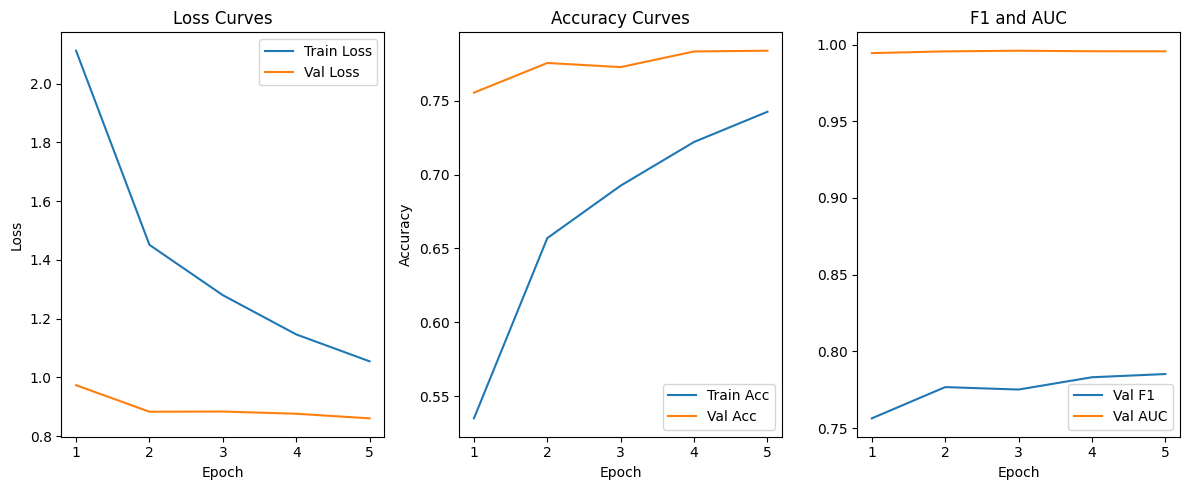

In [10]:
# Plot the saved metrics
import matplotlib.pyplot as plt

# Load metrics from file in case of multiple runs
with open(metrics_history_file, "r") as f:
    history = json.load(f)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.plot(history["epoch"], history["train_loss"], label='Train Loss')
plt.plot(history["epoch"], history["val_loss"], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,3,2)
plt.plot(history["epoch"], history["train_acc"], label='Train Acc')
plt.plot(history["epoch"], history["val_acc"], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history["epoch"], history["val_f1"], label='Val F1')
plt.plot(history["epoch"], history["val_auc"], label='Val AUC')
plt.xlabel('Epoch')
plt.title('F1 and AUC')
plt.legend()

plt.tight_layout()
plt.show()